In [86]:
# ce notebook fait une analyse du retard en fonction du temps pour des faibles retards 
import numpy as np 
import pandas as pd 
import scipy as sc 
import matplotlib.pyplot as plt 
from itertools import product
from sklearn import linear_model
from sklearn.utils import shuffle
import seaborn as sns

import missingno as msno

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import neighbors, metrics
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn import kernel_ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn import dummy
from sklearn.metrics import f1_score

from sklearn import (manifold, datasets, decomposition, ensemble,discriminant_analysis, random_projection)

import timeit

In [87]:
# ouvrir le dataset : 

data_fly = pd.read_csv('DF_CASCADE_DEST.csv')

In [88]:
def plot_value_counts(col_name):       
    
    values_count = pd.DataFrame(df[col_name].dropna().value_counts())
    print (values_count.shape)
    values_count.columns = ['count']
    # convert the index column into a regular column.
    values_count[col_name] = [ str(i) for i in values_count.index ]
    # add a column with the percentage of each data point to the sum of all data points.
    values_count['percent'] = values_count['count'].div(values_count['count'].sum()).multiply(100).round(2)
    # change the order of the columns.
    values_count = values_count.reindex([col_name,'count','percent'],axis=1)
    values_count.reset_index(drop=True,inplace=True)
    
    return (values_count)

In [97]:
df = data_fly.copy()
valeur = plot_value_counts('PROBLEM_SMALL')
print (valeur)

(2, 1)
  PROBLEM_SMALL  count  percent
0           0.0  47033    84.63
1           1.0   8544    15.37


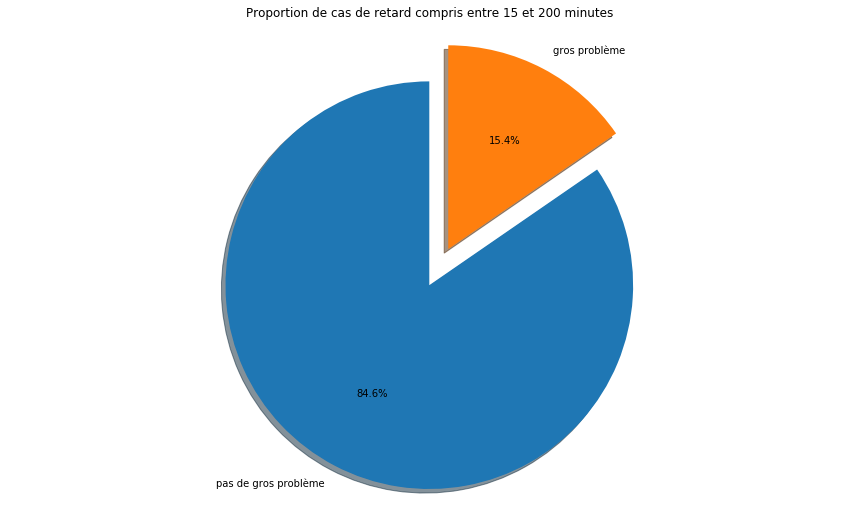

In [98]:
# Set up the matplotlib figure
f, (ax1) = plt.subplots(1, 1, figsize=(15, 9), sharex=True)
explode=(0, 0.2)
plt.pie([232554,42316], explode=explode, labels=['pas de gros problème','gros problème'], autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Proportion de cas de retard compris entre 15 et 200 minutes')
plt.axis('equal')
plt.savefig('pict_smallprob.png', dpi=400)
plt.show()

On annalyse ici différent modèles de regressions logistiques avec ou sans régularisation en fonction des différentes variables prises en compte.
Trois étapes de temps sont à considérer : En premier lieu le retard prévisible longtemps à l'avance ( on base notre analyse sur le reppart au départ ) Ensuite le retard prévisible quelques heures à l'avance ( on base notre analyse sur le retard au départ ) enfin le retard prévisible une fois que l'on connait l'heure de départ de l'avion ( on base notre analyse sur le retard à l'arrivé )

Tous nos modèles vont être testé via une validation croisée sur le jeux d'entrainement, un pré-choix des différents paramétres de régularisation sera effectué via une validation croisée par grille sur la base de l'aire sous la courbe ROC. Le choix final se fera lui aussi sur la base de la meilleure aire sous courbe ROC. (on ne tient pas compte d'éventuelles restrictions de temps de calcul). Enfin, la performance du modèle final sera donnée en l'évaluant via le jeux de test. Le modèle final pourra ensuite être entrainé sur l'ensemble du jeux de donnée.

On cherche ici à savoir si un avion va avoir ou non du retard (on prend en compte ici les retards faibles) (de plus de 15mins et moins de 200mins).

On définie une fonction qui analyse via une cross-validation sur 5 folds les retards de regression logistiques simples non régularisées. 

In [99]:
def analyse(X_fit,y_fit,n):
    # ajouter des features polynomiales couplées 
    poly = PolynomialFeatures(n)
    X_fit = poly.fit_transform(X_fit)
    y_fit = y_fit 
    
    # réaranger 
    y_fit = y_fit.ravel()
    y_fit = np.array(y_fit).astype(int)
    y_fit2 = np.zeros(y_fit.shape[1])
    y_fit2[:] = y_fit[0,:]
    y_fit = y_fit2           
    
    
    # on va standardiser les données de telle sorte à ce que 
    std_scale = preprocessing.StandardScaler().fit(X_fit)
    X_fit = std_scale.transform(X_fit) 
    print (X_fit.shape)
    print (y_fit.shape)
    
    # On crée un modèle de régression logistique

    lr = LogisticRegression(penalty='l2',C=10000,dual=False)
    # évaluation de la rmse par validation croisée (sur 5 folds)
    y_predict_lr = cross_val_predict(lr,X_fit,y_fit,method='predict_proba',cv=5)
    y_predict_lr_occ = cross_val_predict(lr,X_fit,y_fit,cv=5)
    
    accu = accuracy_score(y_fit, y_predict_lr_occ)
    print ('accuracy')
    print (accu)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_fit, y_predict_lr[:,1])
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print ('Aire sous la courbe ROC')
    print (roc_auc)
    f1_sc = f1_score(y_fit, y_predict_lr_occ)
    print ('f1 score')
    print (f1_sc)
    
    if (n==4):    
        # afficher la courbe ROC
        plt.figure(figsize=(10,10))
        plt.title('Receiver Operating Characteristic')
        plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],linestyle='--')
        plt.axis('tight')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        #plt.savefig('pict_rocweekday.png', dpi=400)
        plt.show()    

    return (f1_sc,accu,roc_auc)
    
    

In [100]:
def analyse_stoch(X_fit,y_fit,n):
    # ajouter des features polynomiales couplées 
    poly = PolynomialFeatures(n)
    X_fit = poly.fit_transform(X_fit)
    y_fit = y_fit 
    
    # réaranger 
    y_fit = y_fit.ravel()
    y_fit = np.array(y_fit).astype(int)
    y_fit2 = np.zeros(y_fit.shape[1])
    y_fit2[:] = y_fit[0,:]
    y_fit = y_fit2           
    
    
    # on va standardiser les données de telle sorte à ce que 
    std_scale = preprocessing.StandardScaler().fit(X_fit)
    X_fit = std_scale.transform(X_fit) 
    print (X_fit.shape)
    print (y_fit.shape)
    
    # On crée un modèle SVM avec descente de gradient stochastique

    lr = linear_model.SGDClassifier(loss='log',max_iter=15,penalty=None,learning_rate='optimal')
    # évaluation de la rmse par validation croisée (sur 5 folds)
    y_predict_lr = cross_val_predict(lr,X_fit,y_fit,method='predict_proba',cv=5)
    y_predict_lr_occ = cross_val_predict(lr,X_fit,y_fit,cv=5)
    
    accu = accuracy_score(y_fit, y_predict_lr_occ)
    print ('accuracy')
    print (accu)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_fit, y_predict_lr[:,1])
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print ('Aire sous la courbe ROC')
    print (roc_auc)
    f1_sc = f1_score(y_fit, y_predict_lr_occ)
    print ('f1 score')
    print (f1_sc)
    
    if (n==4):    
        # afficher la courbe ROC
        plt.figure(figsize=(10,10))
        plt.title('Receiver Operating Characteristic')
        plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],linestyle='--')
        plt.axis('tight')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()    

    return (f1_sc,accu,roc_auc)
    
linear_model.SGDClassifier(max_iter=1000)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [177]:
def best_model(X_fit,y_fit,n,params_min,params_max,nb_params):
    # ajouter des features polynomiales couplées 
    poly = PolynomialFeatures(n)
    X_fit = poly.fit_transform(X_fit)
    y_fit = y_fit 
    
    # réaranger 
    y_fit = y_fit.ravel()
    y_fit = np.array(y_fit).astype(int)
    y_fit2 = np.zeros(y_fit.shape[1])
    y_fit2[:] = y_fit[0,:]
    y_fit = y_fit2 
    print (X_fit.shape)
    print (y_fit.shape)
    
    # on va standardiser les données de telle sorte à ce que 
    std_scale = preprocessing.StandardScaler().fit(X_fit)
    X_fit = std_scale.transform(X_fit) 
    
    # On crée un modèle SVM avec descente de gradient stochastique

    lr = linear_model.SGDClassifier(loss='log',max_iter=8,penalty='l2',learning_rate='optimal')
    # évaluation de la rmse par validation croisée (sur 5 folds)
    # grille (échelle logarithmique)
    params = {'alpha': np.logspace(params_min,params_max,nb_params) }

    model_ridge_cv = GridSearchCV(lr,params,scoring='roc_auc',cv=5)
    model_ridge_cv.fit(X_fit,y_fit)
    
    print (params)
    print ('-------voici le meilleur paramètre---------')
    best_params = model_ridge_cv.best_params_
    print (best_params)
    # prédire les valeurs de y_test
    y_predict_lr = model_ridge_cv.predict_proba(X_fit)
    y_predict_lr_occ = model_ridge_cv.predict(X_fit)
    
    accu = accuracy_score(y_fit, y_predict_lr_occ)
    print ('accuracy')
    print (accu)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_fit, y_predict_lr[:,1])
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print ('Aire sous la courbe ROC')
    print (roc_auc)
    f1_sc = f1_score(y_fit, y_predict_lr_occ)
    print ('f1 score')
    print (f1_sc)
    
    if (n==4):
        # afficher la courbe ROC
        plt.figure(figsize=(10,10))
        plt.title('Receiver Operating Characteristic')
        plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],linestyle='--')
        plt.axis('tight')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.savefig('pict_roc_best.png', dpi=400)
        plt.show()    
    
    return (f1_sc,accu,roc_auc)
    
    

In [102]:
# étudier la performance du modèle selectionné
def perform(X_train,X_test,y_train,y_test,alpha,n=4):
    # ajouter des features polynomiales couplées 
    poly = PolynomialFeatures(n)
    X_fit = poly.fit_transform(X_train)
    y_fit = y_train
    X_test_n = poly.fit_transform(X_test)
    print (X_test_n.shape)
    
    # on va standardiser les données de telle sorte à ce que 
    std_scale = preprocessing.StandardScaler().fit(X_fit)
    X_fit = std_scale.transform(X_fit)
    X_test_n= std_scale.transform(X_test_n)
    
    # On crée un modèle de régression linéaire
    lr_model = linear_model.SGDClassifier(loss='log',max_iter=15,penalty='l2',alpha=alpha,learning_rate='optimal')
    # entrainer le modèle 
    lr_model.fit(X_fit,y_fit)    
    
    # prédictions probabilites et non probabilistes    
    y_predict_lr = lr_model.predict_proba(X_test_n)
    y_predict_lr_occ = lr_model.predict(X_test_n)
    
    accu = accuracy_score(y_test, y_predict_lr_occ)
    print ('accuracy')
    print (accu)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predict_lr[:,1])
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print ('Aire sous la courbe ROC')
    print (roc_auc)
    f1_sc = f1_score(y_test, y_predict_lr_occ)
    print ('f1 score')
    print (f1_sc)
    
    if (n==4):
        # afficher la courbe ROC
        plt.figure(figsize=(10,10))
        plt.title('Receiver Operating Characteristic')
        plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],linestyle='--')
        plt.axis('tight')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()    
    
    return (f1_sc,accu,roc_auc,y_predict_lr)    
       

In [103]:
print (data_fly.columns[:])

Index(['Unnamed: 0.1', 'Unnamed: 0.1.1', 'CRS_DEP_TIME', 'DEP_DELAY_NEW',
       'ARR_DELAY_NEW', 'CANCELLED', 'DIVERTED', 'ORIGIN_CITY_NAME',
       'DEST_CITY_NAME', 'TAIL_NUM', 'CRS_ARR_TIME', 'DISTANCE', 'AIR_TIME',
       'DAY', 'DAY_YEAR', 'MINUTES', 'MOY_WD_DAY', 'TR_WD_DAY', 'MOY_ORIG',
       'TR_ORIG', 'MOY_DEST', 'TR_DEST', 'MOY_TAIL', 'TR_TAIL', 'LAT_DEP',
       'LONG_DEP', 'LAT_ARR', 'LONG_ARR', 'HOURS_BEFORE', 'MINUTES_ARR',
       'CASCADE', 'CASCADE_DEST', 'PROBLEM_SMALL'],
      dtype='object')


In [106]:
# analyser la dimmension du dataset
print (data_fly.shape)

(55577, 33)


In [ ]:
# enlever la première colonne
data_fly = data_fly.drop(columns = ['Unnamed: 0'])

In [107]:
# on prend en compte les données dont le retard au départ est inferieur à 200 (retards légers)
data_fly = data_fly[data_fly.loc[:,'DEP_DELAY_NEW'] < 200]

In [108]:
#ajouter une nouvelle colonne (PROBLEM)
vect= np.zeros(data_fly.shape[0])

data_fly['PROBLEM_SMALL'] = vect[:]

In [109]:
# on choisit de  considérer comme "retard" les retards de moins de 200mins et de plus de 15mins 
print (data_fly.shape[0])
data_fly.loc[:,'PROBLEM_SMALL'][(data_fly['DEP_DELAY_NEW'] > 15)&(data_fly['DEP_DELAY_NEW'] <200 )] = 1
print (data_fly.shape[0])

55577
55577


C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [110]:
# supprimer les valeurs inconnues
print (data_fly.shape)
data_fly = data_fly.dropna(0, subset=['CASCADE','CASCADE_DEST','PROBLEM_SMALL'])
print (data_fly.shape)

(55577, 33)
(55538, 33)


In [111]:
# mélanger les données : 
data_fly = shuffle(data_fly)

In [112]:
# choisir les variables qui nous interessent pour l'étude des correlations
data_fly_corr = data_fly[['PROBLEM_SMALL','DISTANCE', 'AIR_TIME', 'DAY', 'DAY_YEAR', 'MINUTES',
       'MOY_WD_DAY', 'TR_WD_DAY', 'MOY_ORIG', 'TR_ORIG', 'MOY_DEST', 'TR_DEST',
       'MOY_TAIL', 'TR_TAIL', 'LAT_DEP', 'LONG_DEP', 'LAT_ARR', 'LONG_ARR',
       'HOURS_BEFORE', 'CASCADE']]

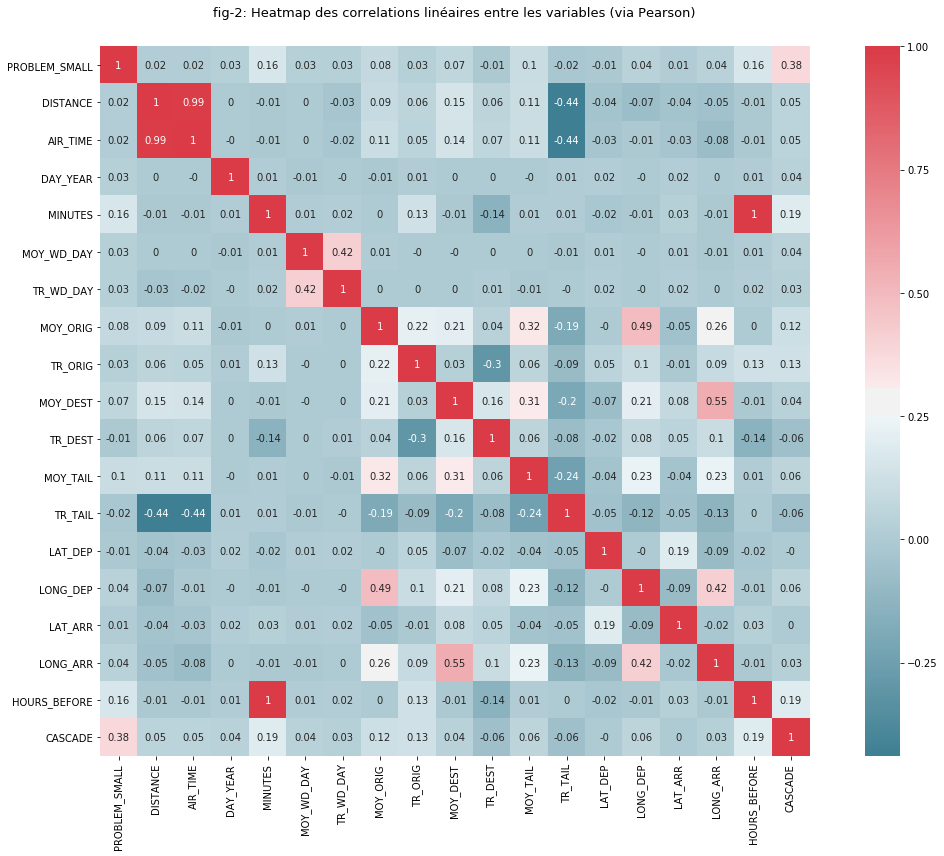

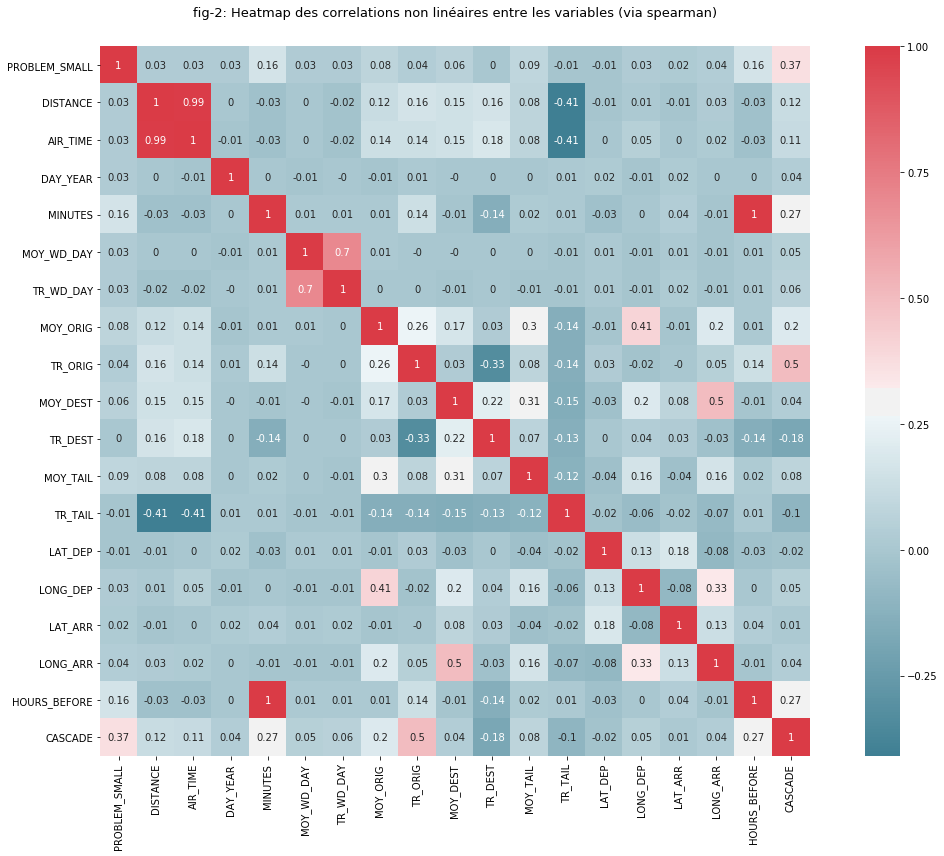

In [113]:
f, ax = plt.subplots(figsize=(16, 12))


corr = data_fly_corr.corr(method='pearson')
corr = np.around(corr,2)
sns.heatmap(corr, annot=True ,mask=np.zeros_like((corr), dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title('fig-2: Heatmap des correlations linéaires entre les variables (via Pearson)',fontsize=13,loc='center', pad = 30)
plt.tight_layout(h_pad=2)
plt.savefig('correlation', dpi=400)
plt.show()

f, ax = plt.subplots(figsize=(16, 12))


corr = data_fly_corr.corr(method='spearman')
corr = np.around(corr,2)
sns.heatmap(corr, annot=True ,mask=np.zeros_like((corr), dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title('fig-2: Heatmap des correlations non linéaires entre les variables (via spearman)',fontsize=13,loc='center', pad = 30)
plt.tight_layout(h_pad=2)
plt.savefig('correlation', dpi=400)
plt.show()

In [114]:
df = data_fly.copy()
df = df.dropna(0, how='any')

In [115]:
# créer une liste qui prend en compte les résultats de nos différents modèles
liste_roc = []
liste_f1 = []
# noms
liste_name = []

In [116]:
data_fly = df[['PROBLEM_SMALL','MINUTES','DAY_YEAR','MOY_WD_DAY','MOY_ORIG','MOY_DEST','MOY_TAIL','CASCADE']   ]

In [117]:
# creation des tenseurs numpy 
# creation des vecteurs X et y 
# variables éventuelles 
X = np.matrix(data_fly.iloc[:,:])
# scores éventuels 
y = np.transpose(np.matrix(data_fly.iloc[:,0]))

#X = np.transpose(X)
#y = np.transpose(y)
print (X.shape)
print (y.shape)

(55409, 8)
(55409, 1)


In [118]:
# créer un jeux de test et un jeux d'entrainement
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=41)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(37124, 8) (18285, 8) (37124, 1) (18285, 1)


# En prenant en compte les jours de la semaine


In [119]:
# régression logistique linéaire 
f1, accu, roc = analyse(X_fit=X_train[:,3],y_fit=y_train,n=1)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('week_day_linear')

(37124, 2)
(37124,)
accuracy
0.8483191466436807
Aire sous la courbe ROC
0.5228259139685973
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [120]:
# régression logistique poly(n=2)
f1, accu, roc = analyse(X_fit=X_train[:,3],y_fit=y_train,n=2)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('week_day_poly2')

(37124, 3)
(37124,)
accuracy
0.8483191466436807
Aire sous la courbe ROC
0.5253182522462039
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [121]:
# régression logistique poly(n=3)
f1, accu, roc = analyse(X_fit=X_train[:,3],y_fit=y_train,n=3)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('week_day_poly3')

(37124, 4)
(37124,)
accuracy
0.8483191466436807
Aire sous la courbe ROC
0.5249705020804927
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(37124, 5)
(37124,)
accuracy
0.8483191466436807
Aire sous la courbe ROC
0.5246670348130176
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


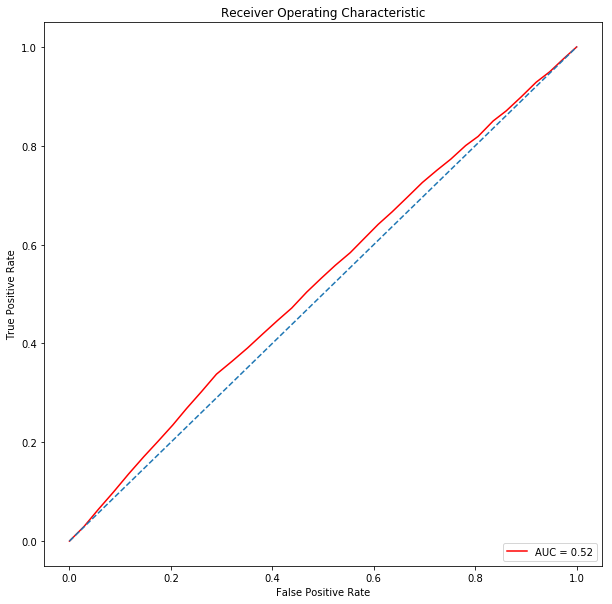

In [122]:
# régression logistique poly(n=4)
f1, accu, roc = analyse(X_fit=X_train[:,3],y_fit=y_train,n=4)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('week_day_poly4')

# En prenant en compte les jours de l'année uniquement


In [123]:
# régression logistique linéaire 
f1, accu, roc = analyse(X_fit=X_train[:,2],y_fit=y_train,n=1)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('year_day_linear')

(37124, 2)
(37124,)
accuracy
0.8483191466436807
Aire sous la courbe ROC
0.5195752092076533
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [124]:
# régression logistique poly(n=2)
f1, accu, roc = analyse(X_fit=X_train[:,2],y_fit=y_train,n=2)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('year_day_poly2')

(37124, 3)
(37124,)
accuracy
0.8483191466436807
Aire sous la courbe ROC
0.5291369092836606
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [125]:
# régression logistique poly(n=3)
f1, accu, roc = analyse(X_fit=X_train[:,2],y_fit=y_train,n=3)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('year_day_poly3')

(37124, 4)
(37124,)
accuracy
0.8483191466436807
Aire sous la courbe ROC
0.5288838770399759
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(37124, 5)
(37124,)
accuracy
0.8483191466436807
Aire sous la courbe ROC
0.5369793186459484
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


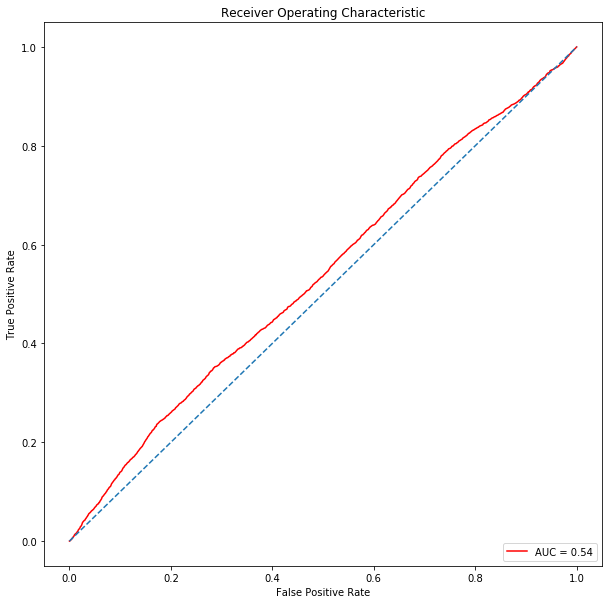

In [126]:
# régression logistique poly(n=4)
f1, accu, roc = analyse(X_fit=X_train[:,2],y_fit=y_train,n=4)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('year_day_poly4')

# Considérer les jours de l'année + les jours de la semaine


In [127]:
# régression logistique linéaire 
f1, accu, roc = analyse(X_fit=X_train[:,2:4],y_fit=y_train,n=1)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('tot_day_linear')

(37124, 3)
(37124,)
accuracy
0.8483191466436807
Aire sous la courbe ROC
0.5322531215876602
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [128]:
# régression logistique poly(n=2) 
f1, accu, roc = analyse(X_fit=X_train[:,2:4],y_fit=y_train,n=2)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('tot_day_poly2')

(37124, 6)
(37124,)
accuracy
0.8483191466436807
Aire sous la courbe ROC
0.5469411042472149
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [129]:
# régression logistique poly(n=3) 
f1, accu, roc = analyse(X_fit=X_train[:,2:4],y_fit=y_train,n=3)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('tot_day_poly3')

(37124, 10)
(37124,)
accuracy
0.8483191466436807
Aire sous la courbe ROC
0.5506338344360835
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(37124, 15)
(37124,)
accuracy
0.8483191466436807
Aire sous la courbe ROC
0.555225899932052
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


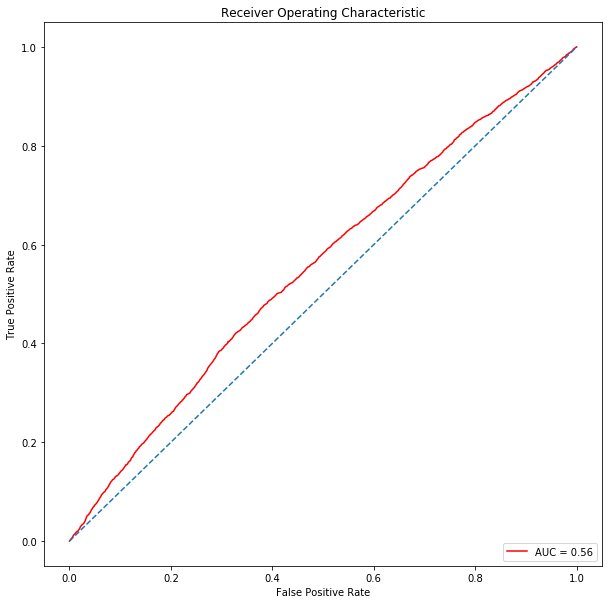

In [130]:
# régression logistique poly(n=4) 
f1, accu, roc = analyse(X_fit=X_train[:,2:4],y_fit=y_train,n=4)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('tot_day_poly4')

# considérer l'heure seule


In [131]:
# régression logistique linéaire 
f1, accu, roc = analyse(X_fit=X_train[:,1],y_fit=y_train,n=1)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_linear')

(37124, 2)
(37124,)
accuracy
0.8483191466436807
Aire sous la courbe ROC
0.6343163065335862
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [132]:
# régression logistique poly(n=2)
f1, accu, roc = analyse(X_fit=X_train[:,1],y_fit=y_train,n=2)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_poly2')

(37124, 3)
(37124,)
accuracy
0.8483191466436807
Aire sous la courbe ROC
0.634762039589881
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [133]:
# régression logistique poly(n=3)
f1, accu, roc = analyse(X_fit=X_train[:,1],y_fit=y_train,n=3)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_poly3')

(37124, 4)
(37124,)
accuracy
0.8483191466436807
Aire sous la courbe ROC
0.6363682180336755
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(37124, 5)
(37124,)
accuracy
0.8483191466436807
Aire sous la courbe ROC
0.6351820307092793
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


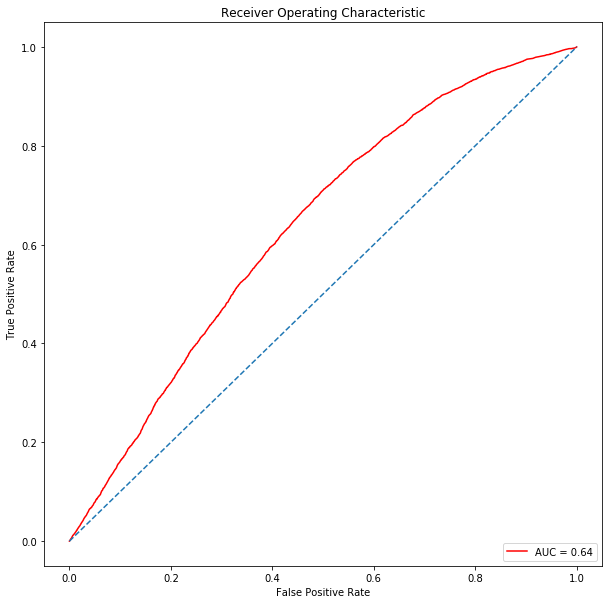

In [134]:
# régression logistique poly(n=4)
f1, accu, roc = analyse(X_fit=X_train[:,1],y_fit=y_train,n=4)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_poly4')

# heure et jours de l'année

In [135]:
# régression logistique linéaire 
f1, accu, roc = analyse(X_fit=X_train[:,1:3],y_fit=y_train,n=1)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_year_linear')

(37124, 3)
(37124,)
accuracy
0.8483191466436807
Aire sous la courbe ROC
0.6353746864100612
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [136]:
# régression logistique poly(n=2)
f1, accu, roc = analyse(X_fit=X_train[:,1:3],y_fit=y_train,n=2)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_year_poly2')

(37124, 6)
(37124,)
accuracy
0.8483191466436807
Aire sous la courbe ROC
0.6432389806479449
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [137]:
# régression logistique poly(n=3)
f1, accu, roc = analyse(X_fit=X_train[:,1:3],y_fit=y_train,n=3)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_year_poly3')

(37124, 10)
(37124,)
accuracy
0.8483191466436807
Aire sous la courbe ROC
0.643675200747494
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(37124, 15)
(37124,)
accuracy
0.8483191466436807
Aire sous la courbe ROC
0.6460144069246927
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


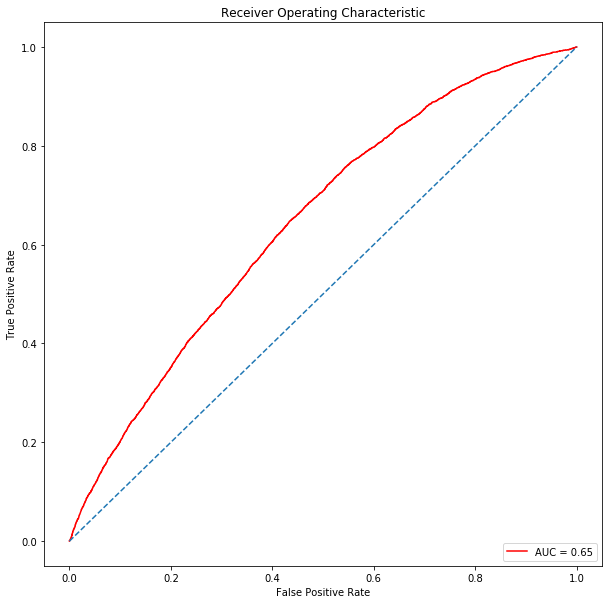

In [138]:
# régression logistique poly(n=4)
f1, accu, roc = analyse(X_fit=X_train[:,1:3],y_fit=y_train,n=4)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_year_poly4')

# heure jours de l'année et jours de la semaine


In [139]:
# régression logistique linéaire 
f1, accu, roc = analyse(X_fit=X_train[:,1:4],y_fit=y_train,n=1)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_linear')

(37124, 4)
(37124,)
accuracy
0.8483191466436807
Aire sous la courbe ROC
0.636913450865773
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [140]:
# régression logistique poly(n=2)
f1, accu, roc = analyse(X_fit=X_train[:,1:4],y_fit=y_train,n=2)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_poly2')

(37124, 10)
(37124,)
accuracy
0.8483191466436807
Aire sous la courbe ROC
0.6485580317118445
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [141]:
# régression logistique poly(n=3)
f1, accu, roc = analyse(X_fit=X_train[:,1:4],y_fit=y_train,n=3)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_poly3')

(37124, 20)
(37124,)
accuracy
0.8483191466436807
Aire sous la courbe ROC
0.6489877331522365
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(37124, 35)
(37124,)
accuracy
0.8483191466436807
Aire sous la courbe ROC
0.6513232796323823
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


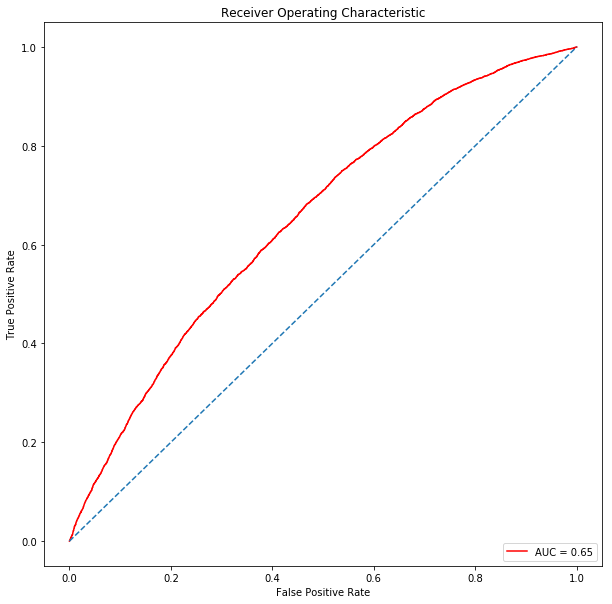

In [142]:
# régression logistique poly(n=4)
f1, accu, roc = analyse(X_fit=X_train[:,1:4],y_fit=y_train,n=4)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_poly4')

# Heure / jours de l'année / jours de la semaine / orig


In [143]:
# régression logistique linéaire 
f1, accu, roc = analyse(X_fit=X_train[:,1:5],y_fit=y_train,n=1)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_origin_linear')

(37124, 5)
(37124,)
accuracy
0.8482652731386704
Aire sous la courbe ROC
0.6503256400129238
f1 score
0.000354924578527063


In [144]:
# régression logistique poly(n=2)
f1, accu, roc = analyse(X_fit=X_train[:,1:5],y_fit=y_train,n=2)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_origin_poly2')

(37124, 15)
(37124,)
accuracy
0.8482652731386704
Aire sous la courbe ROC
0.663930177536528
f1 score
0.0


In [145]:
# le temps de calcul est trop long, on passe à une descende de gradient stochastique
# régression logistique poly(n=3)
start = timeit.timeit()
f1, accu, roc = analyse_stoch(X_fit=X_train[:,1:5],y_fit=y_train,n=3)[:]
end = timeit.timeit()
print ('-----time ---------')
print (end - start)
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_origin_poly3')

(37124, 35)
(37124,)
accuracy
0.8355511259562547
Aire sous la courbe ROC
0.6467638525440277
f1 score
0.08126410835214447
-----time ---------
-0.006501781461338396


(37124, 70)
(37124,)
accuracy
0.825800021549402
Aire sous la courbe ROC
0.5674026424580357
f1 score
0.05134223265365996


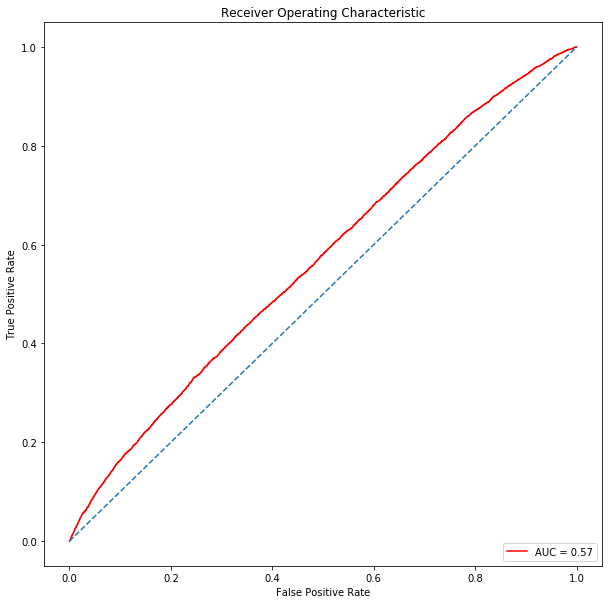

In [146]:
# le temps de calcul est trop long, on passe à une descende de gradient stochastique
# régression logistique poly(n=4)
f1, accu, roc = analyse_stoch(X_fit=X_train[:,1:5],y_fit=y_train,n=4)[:]

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_origin_poly4')

In [147]:
# on rajouter de la regularisation (poly n=3)
f1, accu, roc = best_model(X_fit=X_train[:,1:5],y_fit=y_train,n=3,params_min=-1,params_max=1,nb_params=5)

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_origin_poly3reg')

(37124, 35)
(37124,)
{'alpha': array([ 0.1       ,  0.31622777,  1.        ,  3.16227766, 10.        ])}
-------voici le meilleur paramètre---------
{'alpha': 0.1}
accuracy
0.8482652731386704
Aire sous la courbe ROC
0.6562562439351729
f1 score
0.000354924578527063


(37124, 70)
(37124,)
{'alpha': array([ 0.1       ,  0.31622777,  1.        ,  3.16227766, 10.        ])}
-------voici le meilleur paramètre---------
{'alpha': 0.1}
accuracy
0.8481575261286499
Aire sous la courbe ROC
0.6597915789558804
f1 score
0.0007090941322460556


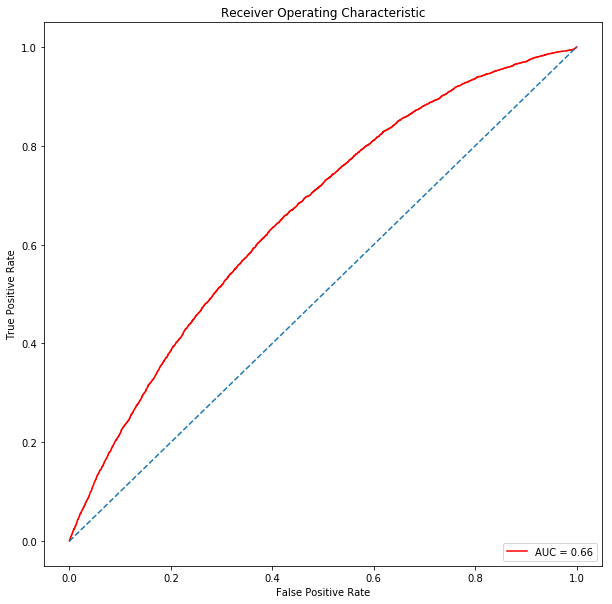

In [148]:
# on rajouter de la regularisation (poly n=4)
f1, accu, roc = best_model(X_fit=X_train[:,1:5],y_fit=y_train,n=4,params_min=-1,params_max=1,nb_params=5)

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_origin_poly4')

# heure / jours de l'année / jours de la semaine / orig / arriv


In [149]:
# régression logistique linéaire 
f1, accu, roc = analyse(X_fit=X_train[:,1:6],y_fit=y_train,n=1)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_path_linear')

(37124, 6)
(37124,)
accuracy
0.8481305893761448
Aire sous la courbe ROC
0.654679715240382
f1 score
0.00035460992907801415


In [150]:
# régression logistique poly(n=2)
f1, accu, roc = analyse(X_fit=X_train[:,1:6],y_fit=y_train,n=2)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_path_poly2')

(37124, 21)
(37124,)
accuracy
0.8482922098911755
Aire sous la courbe ROC
0.6681295079157246
f1 score
0.0


In [151]:
# le temps de calcul est trop long, on passe à une descende de gradient stochastique
# régression logistique poly(n=3)
f1, accu, roc = analyse_stoch(X_fit=X_train[:,1:6],y_fit=y_train,n=3)[:]

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_path_poly3')

(37124, 56)
(37124,)
accuracy
0.817341881262795
Aire sous la courbe ROC
0.5862658967949755
f1 score
0.14066658218223294


(37124, 126)
(37124,)
accuracy
0.8083450059260856
Aire sous la courbe ROC
0.5674264756007067
f1 score
0.15226974860002382


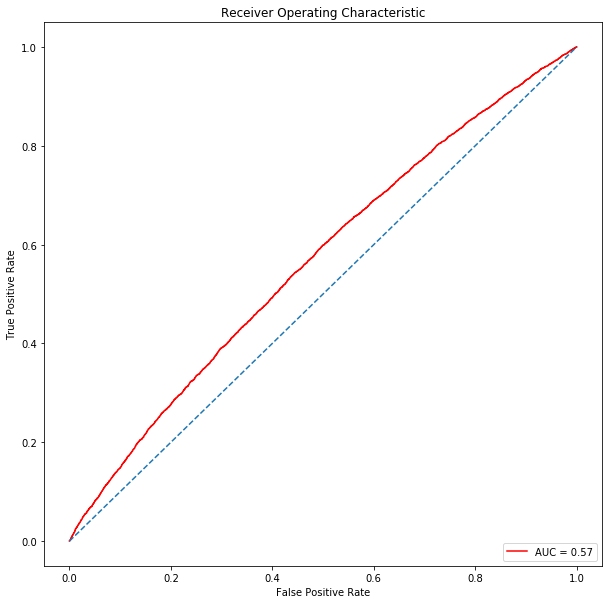

In [152]:
# le temps de calcul est trop long, on passe à une descende de gradient stochastique
# régression logistique poly(n=4)
f1, accu, roc = analyse_stoch(X_fit=X_train[:,1:6],y_fit=y_train,n=4)[:]

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_path_poly4')

In [153]:
# on rajouter de la regularisation (poly n=3)
f1, accu, roc = best_model(X_fit=X_train[:,1:6],y_fit=y_train,n=3,params_min=-3,params_max=4,nb_params=5)

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_path_poly3reg')

(37124, 56)
(37124,)
{'alpha': array([1.00000000e-03, 5.62341325e-02, 3.16227766e+00, 1.77827941e+02,
       1.00000000e+04])}
-------voici le meilleur paramètre---------
{'alpha': 0.05623413251903491}
accuracy
0.8480767158711345
Aire sous la courbe ROC
0.6632809901356052
f1 score
0.0010626992561105207


(37124, 126)
(37124,)
{'alpha': array([1.00000000e-01, 1.77827941e+00, 3.16227766e+01, 5.62341325e+02,
       1.00000000e+04])}
-------voici le meilleur paramètre---------
{'alpha': 0.1}
accuracy
0.8480767158711345
Aire sous la courbe ROC
0.6655649004895384
f1 score
0.0010626992561105207


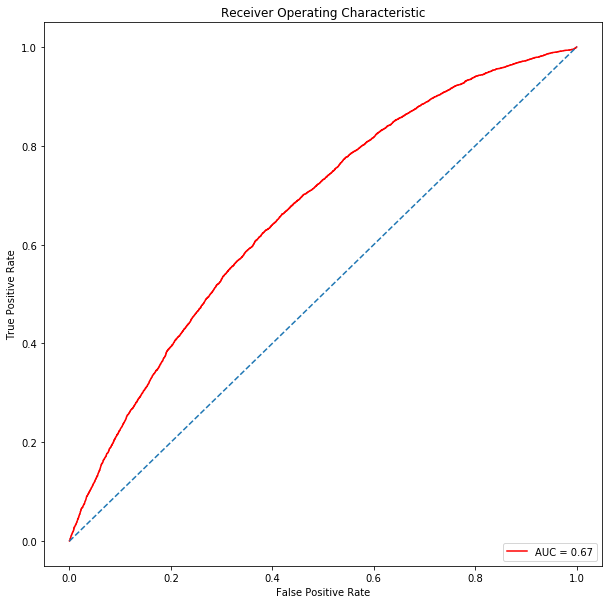

In [154]:
# on rajouter de la regularisation (poly n=4)
f1, accu, roc = best_model(X_fit=X_train[:,1:6],y_fit=y_train,n=4,params_min=-1,params_max=4,nb_params=5)

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_path_poly4reg')

# heure / jours de l'année / jours de la semaine / orig / arriv / appareil


In [155]:
# régression logistique linéaire 
f1, accu, roc = analyse(X_fit=X_train[:,1:7],y_fit=y_train,n=1)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_path_aircraft_linear')

(37124, 7)
(37124,)
accuracy
0.8480228423661244
Aire sous la courbe ROC
0.6633132112588094
f1 score
0.005990133897110641


In [156]:
# régression logistique poly(n=2)
f1, accu, roc = analyse(X_fit=X_train[:,1:7],y_fit=y_train,n=2)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_path_aircraft_poly2')

(37124, 28)
(37124,)
accuracy
0.8481575261286499
Aire sous la courbe ROC
0.6766602899405987
f1 score
0.004942630185348633


In [157]:
# le temps de calcul est trop long, on passe à une descende de gradient stochastique
# régression logistique poly(n=3)
f1, accu, roc = analyse_stoch(X_fit=X_train[:,1:7],y_fit=y_train,n=3)[:]

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_path_aircraft_poly3')

(37124, 84)
(37124,)
accuracy
0.830810257515354
Aire sous la courbe ROC
0.5982150332313744
f1 score
0.11969166082690959


(37124, 210)
(37124,)
accuracy
0.7902973817476565
Aire sous la courbe ROC
0.5786305591820297
f1 score
0.15371236003913466


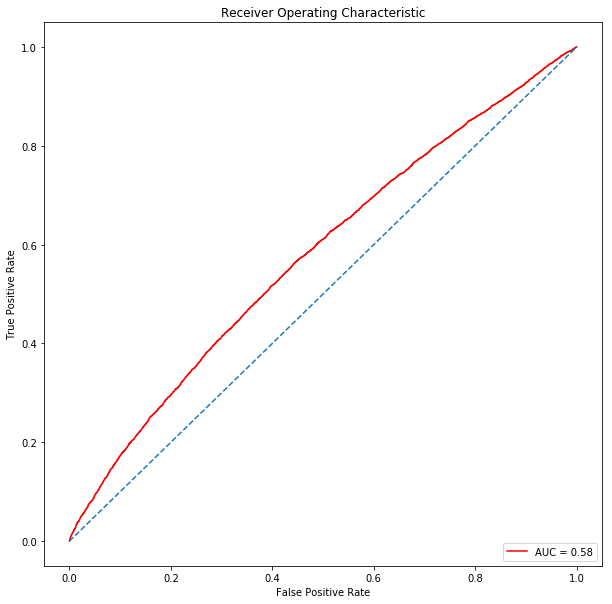

In [158]:
# le temps de calcul est trop long, on passe à une descende de gradient stochastique
# régression logistique poly(n=4)
f1, accu, roc = analyse_stoch(X_fit=X_train[:,1:7],y_fit=y_train,n=4)[:]

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_path_aircraft_poly4')

In [159]:
# on rajouter de la regularisation (poly n=3)
f1, accu, roc = best_model(X_fit=X_train[:,1:7],y_fit=y_train,n=3,params_min=-1,params_max=4,nb_params=5)

liste_f1.append(f1)
liste_roc.append(roc)

liste_name.append('hour_day_tot_path_aircraft_poly3reg')

(37124, 84)
(37124,)
{'alpha': array([1.00000000e-01, 1.77827941e+00, 3.16227766e+01, 5.62341325e+02,
       1.00000000e+04])}
-------voici le meilleur paramètre---------
{'alpha': 0.1}
accuracy
0.8481036526236397
Aire sous la courbe ROC
0.6707066733470517
f1 score
0.012261341741110527


(37124, 210)
(37124,)
{'alpha': array([1.00000000e-01, 1.77827941e+00, 3.16227766e+01, 5.62341325e+02,
       1.00000000e+04])}
-------voici le meilleur paramètre---------
{'alpha': 0.1}
accuracy
0.8482113996336602
Aire sous la courbe ROC
0.6748945284049812
f1 score
0.0038889870956337284


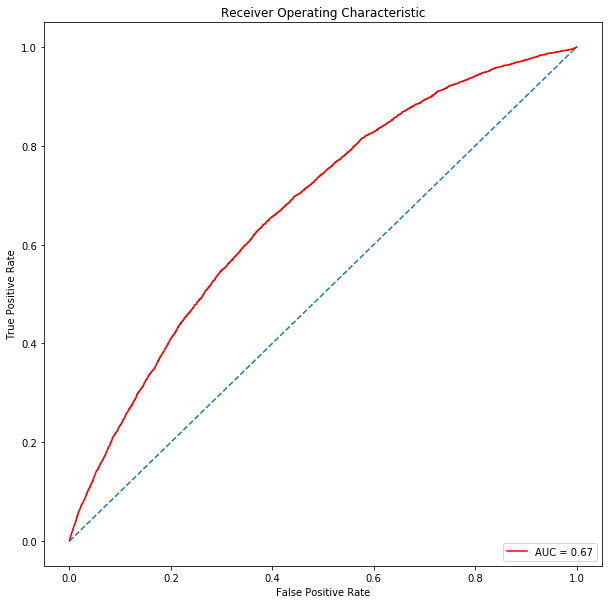

In [160]:
# on rajouter de la regularisation (poly n=4)
f1, accu, roc = best_model(X_fit=X_train[:,1:7],y_fit=y_train,n=4,params_min=-1,params_max=4,nb_params=5)

liste_f1.append(f1)
liste_roc.append(roc)

liste_name.append('hour_day_tot_path_aircraft_poly4reg')

# 2 cas où tente de prédir le retard au départ légérement avant


In [161]:
# régression logistique linéaire 
f1, accu, roc = analyse(X_fit=X_train[:,1:8],y_fit=y_train,n=1)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('before_linear')

(37124, 8)
(37124,)
accuracy
0.8614373451136731
Aire sous la courbe ROC
0.7947327576150557
f1 score
0.29534246575342465


In [162]:
# régression logistique poly(n=2)
f1, accu, roc = analyse(X_fit=X_train[:,1:8],y_fit=y_train,n=2)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('before_poly2')

(37124, 36)
(37124,)
accuracy
0.861410408361168
Aire sous la courbe ROC
0.8058637459374474
f1 score
0.34349878780145465


In [163]:
# le temps de calcul est trop long, on passe à une descende de gradient stochastique
# régression logistique poly(n=3)
f1, accu, roc = analyse_stoch(X_fit=X_train[:,1:8],y_fit=y_train,n=3)[:]

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('before_poly3')

(37124, 120)
(37124,)
accuracy
0.8333692490033402
Aire sous la courbe ROC
0.737875870553256
f1 score
0.349663582842725


(37124, 330)
(37124,)
accuracy
0.7793071867255683
Aire sous la courbe ROC
0.6425575580263716
f1 score
0.31502382743917734


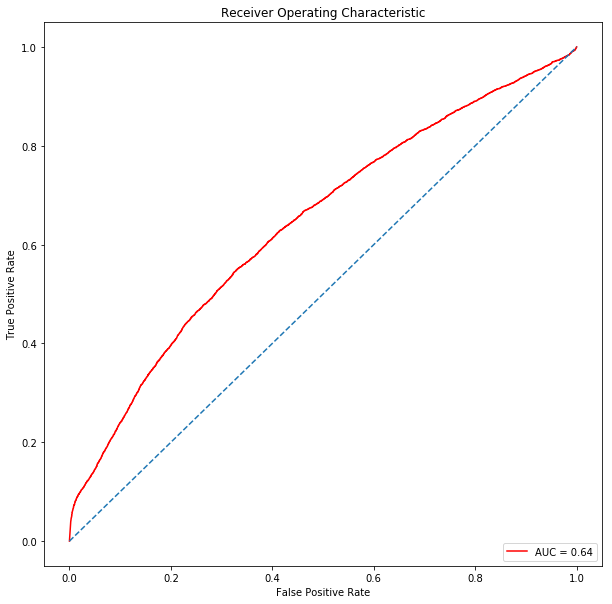

In [164]:
# le temps de calcul est trop long, on passe à une descende de gradient stochastique
# régression logistique poly(n=3)
f1, accu, roc = analyse_stoch(X_fit=X_train[:,1:8],y_fit=y_train,n=4)[:]

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('before_poly3')

In [165]:
# le temps de calcul est trop long, on passe à une descende de gradient stochastique
# régression logistique poly(n=3)
# on rajouter de la regularisation (poly n=4)
f1, accu, roc = best_model(X_fit=X_train[:,1:8],y_fit=y_train,n=3,params_min=-1,params_max=4,nb_params=5)

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('before_poly3reg')

(37124, 120)
(37124,)
{'alpha': array([1.00000000e-01, 1.77827941e+00, 3.16227766e+01, 5.62341325e+02,
       1.00000000e+04])}
-------voici le meilleur paramètre---------
{'alpha': 0.1}
accuracy
0.8620568904212909
Aire sous la courbe ROC
0.8024873962768407
f1 score
0.2968556913359879


(37124, 330)
(37124,)
{'alpha': array([1.00000000e-04, 5.99484250e-04, 3.59381366e-03, 2.15443469e-02,
       1.29154967e-01, 7.74263683e-01, 4.64158883e+00, 2.78255940e+01,
       1.66810054e+02, 1.00000000e+03])}
-------voici le meilleur paramètre---------
{'alpha': 0.021544346900318846}
accuracy
0.8610332938260963
Aire sous la courbe ROC
0.7699830215432154
f1 score
0.3378256963162623


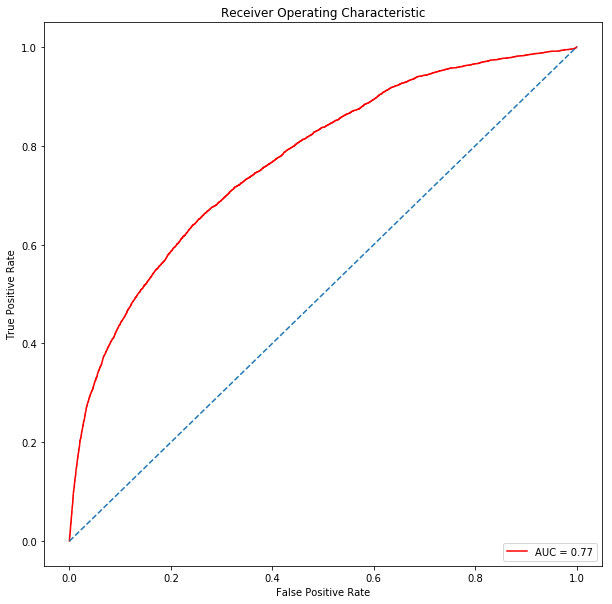

In [179]:
# le temps de calcul est trop long, on passe à une descende de gradient stochastique
# régression logistique poly(n=3)
# on rajouter de la regularisation (poly n=4)
f1, accu, roc = best_model(X_fit=X_train[:,1:8],y_fit=y_train,n=4,params_min=-4,params_max=3,nb_params=10)


liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('before_poly4reg')

# Performance des modèles finaux sur le test set


(18285, 210)


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy
0.8427126059611704
Aire sous la courbe ROC
0.6568524214845122
f1 score
0.012362637362637364


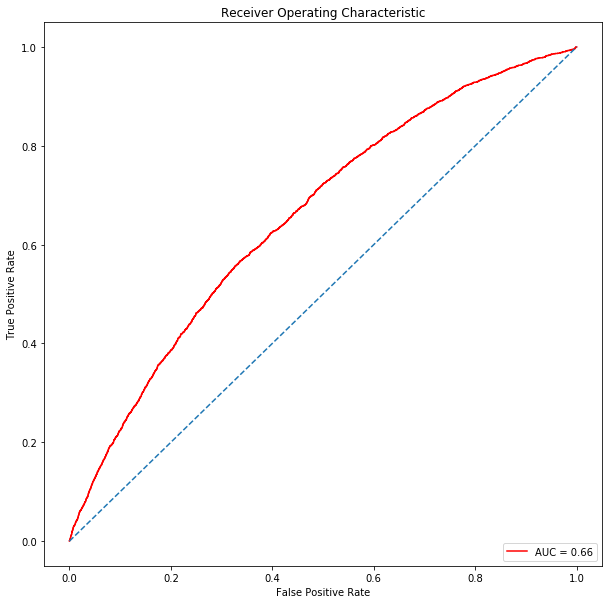

In [167]:
# performance sur le modèle final dans le cas où on cherche à prédire de retard au départ longtemps à l'avance 
X_fit = X_train[:,1:7]
X_fit_t = X_test[:,1:7]

y_train = y_train
y_test = y_test

alpha = 0.1
f1, accu, roc, y_predict_lr = perform(X_train=X_fit,X_test=X_fit_t,y_train=y_train,y_test=y_test,alpha=alpha,n=4)[:]


<function matplotlib.pyplot.show(*args, **kw)>

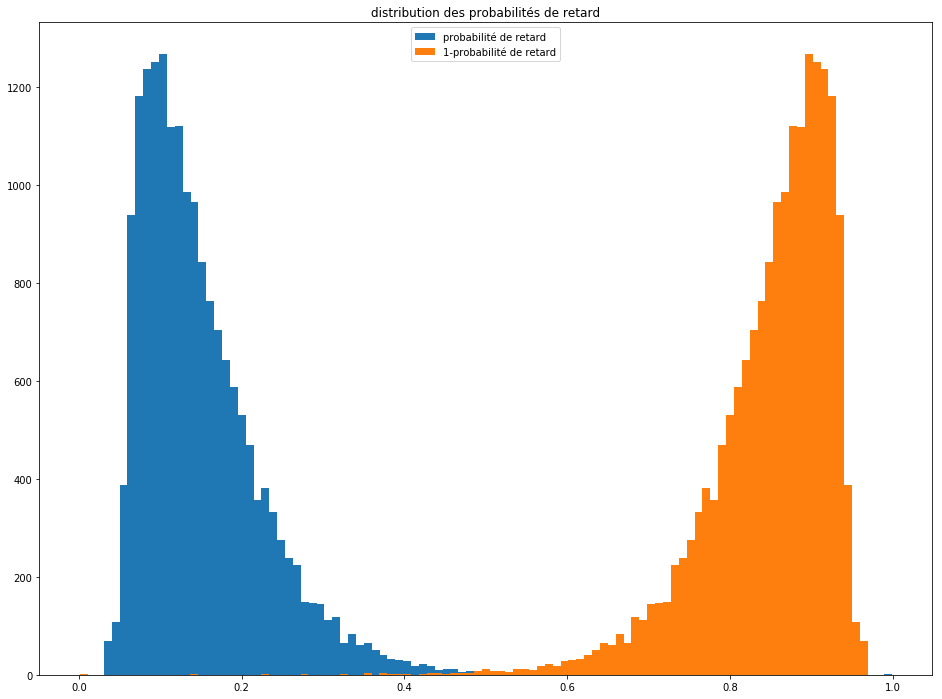

In [168]:

# on regarde l'histogramme des prédictions
fig = plt.figure(figsize=(16, 12))
plt.hist(y_predict_lr[:,1], bins=100, label='probabilité de retard')
plt.hist(y_predict_lr[:,0], bins=100, label='1-probabilité de retard')
plt.title('distribution des probabilités de retard')
plt.legend()
plt.savefig('pict_histprob.png', dpi=400)

plt.show

In [169]:
# on note les différent percentiles (utile dans l'API pour afficher les résultats en nuances de couleur)
print(np.mean(y_predict_lr[:,1]))
print(np.percentile(y_predict_lr[:,1], 33.333))
print(np.percentile(y_predict_lr[:,1], 16.666))
print(np.percentile(y_predict_lr[:,1], 66.666))
print(np.percentile(y_predict_lr[:,1], 83.666))



0.14982356361857058
0.10513221676627905
0.0818628155757671
0.16529199228461566
0.2174122421375267


(18285, 330)


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy
0.8564943943122778
Aire sous la courbe ROC
0.7961707109746007
f1 score
0.3127291775798848


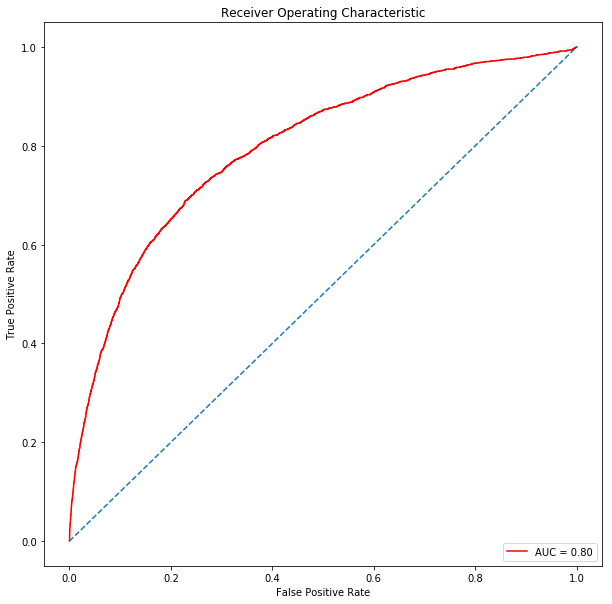

In [170]:
# performance sur le modèle final dans le cas où on cherche à prédire le retard au départ quelques heures à l'avance
X_fit = X_train[:,1:8]
X_fit_t = X_test[:,1:8]

y_train = y_train
y_test = y_test

alpha = 0.017782794
f1, accu, roc,y_predict_lr = perform(X_train=X_fit,X_test=X_fit_t,y_train=y_train,y_test=y_test,alpha=alpha,n=4)[:]

<function matplotlib.pyplot.show(*args, **kw)>

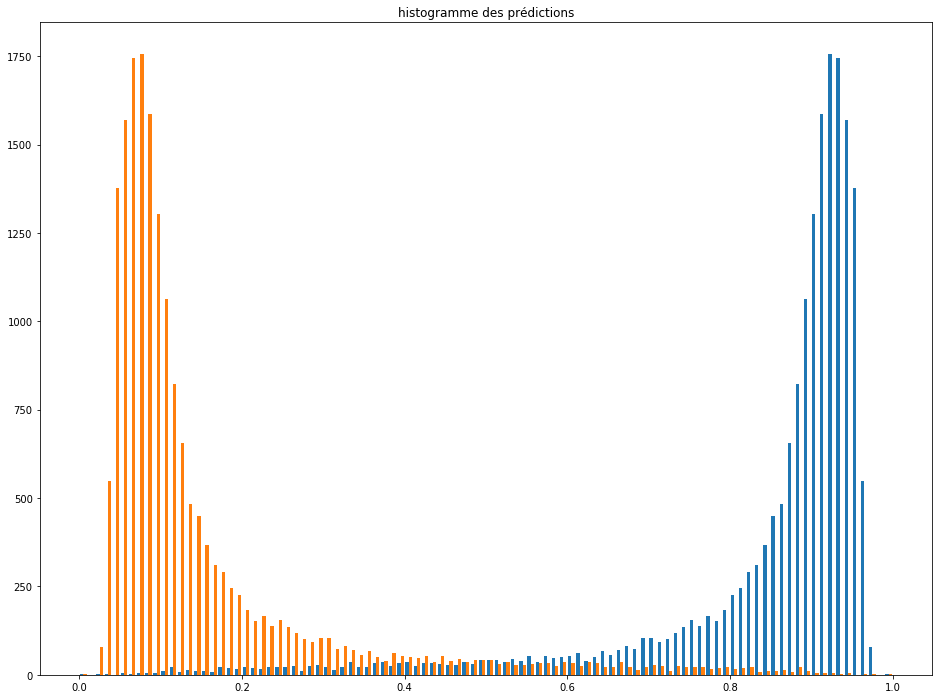

In [171]:
# on regarde l'histogramme des prédictions
fig = plt.figure(figsize=(16, 12))
plt.hist(y_predict_lr[:], bins=100)
plt.title('histogramme des prédictions')

plt.show

In [172]:
# on note les différent percentiles (utile dans l'API pour afficher les résultats en nuances de couleur)
print(np.mean(y_predict_lr[:,1]))
print(np.percentile(y_predict_lr[:,1], 33.333))
print(np.percentile(y_predict_lr[:,1], 16.666))
print(np.percentile(y_predict_lr[:,1], 66.666))
print(np.percentile(y_predict_lr[:,1], 83.666))


0.14960182653380416
0.07441746081344769
0.05680573048516841
0.12520029830831936
0.2235549656237524


# Enregistrement des modèles utilisés dans l'API

In [173]:
from sklearn.externals import joblib

In [174]:
# sauvegarde du modèle final dans le cas où on cherche à prédire de retard au départ longtemps à l'avance 
X_fit = X[:,1:7]
y_fit = y

alpha = 0.1
# ajouter des features polynomiales couplées 
poly = PolynomialFeatures(4)
X_fit = poly.fit_transform(X_fit)
y_fit = y_fit
    
# on va standardiser les données de telle sorte à ce que 
std_scale = preprocessing.StandardScaler().fit(X_fit)
# on enregistre le scaler
joblib.dump(std_scale, 'model_bprobs_scaler.joblib') 

X_fit = std_scale.transform(X_fit)

# On crée un modèle de SGDC
model_big_prob_small = linear_model.SGDClassifier(loss='log',max_iter=10,penalty='l2',alpha=alpha,learning_rate='optimal')
# entrainer le modèle 
model_big_prob_small.fit(X_fit,y_fit)   
    
#SAVE 
joblib.dump(model_big_prob_small, 'model_big_prob_small.joblib') 

C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['model_big_prob_small.joblib']

In [175]:
# sauvegarde du modèle final dans le cas où on cherche à prédire de retard au départ quelques heures à l'avance 
X_fit = X[:,1:8]
y_fit = y

alpha = 0.017782794
# ajouter des features polynomiales couplées 
poly = PolynomialFeatures(4)
X_fit = poly.fit_transform(X_fit)
y_fit = y_fit
    
# on va standardiser les données de telle sorte à ce que 
std_scale = preprocessing.StandardScaler().fit(X_fit)
# on enregistre le scaler
joblib.dump(std_scale, 'model_mprobs_scaler.joblib') 

X_fit = std_scale.transform(X_fit)
    
# On crée un modèle de SGDC
model_medium_prob_small = linear_model.SGDClassifier(loss='log',max_iter=10,penalty='l2',alpha=alpha,learning_rate='optimal')
# entrainer le modèle 
model_medium_prob_small.fit(X_fit,y_fit)  
    

joblib.dump(model_medium_prob_small, 'model_medium_prob_small.joblib') 

C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['model_medium_prob_small.joblib']

No handles with labels found to put in legend.
C:\Users\tanne\Anaconda3\lib\site-packages\matplotlib\legend.py:641: UserWarning: Unrecognized location "modele". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


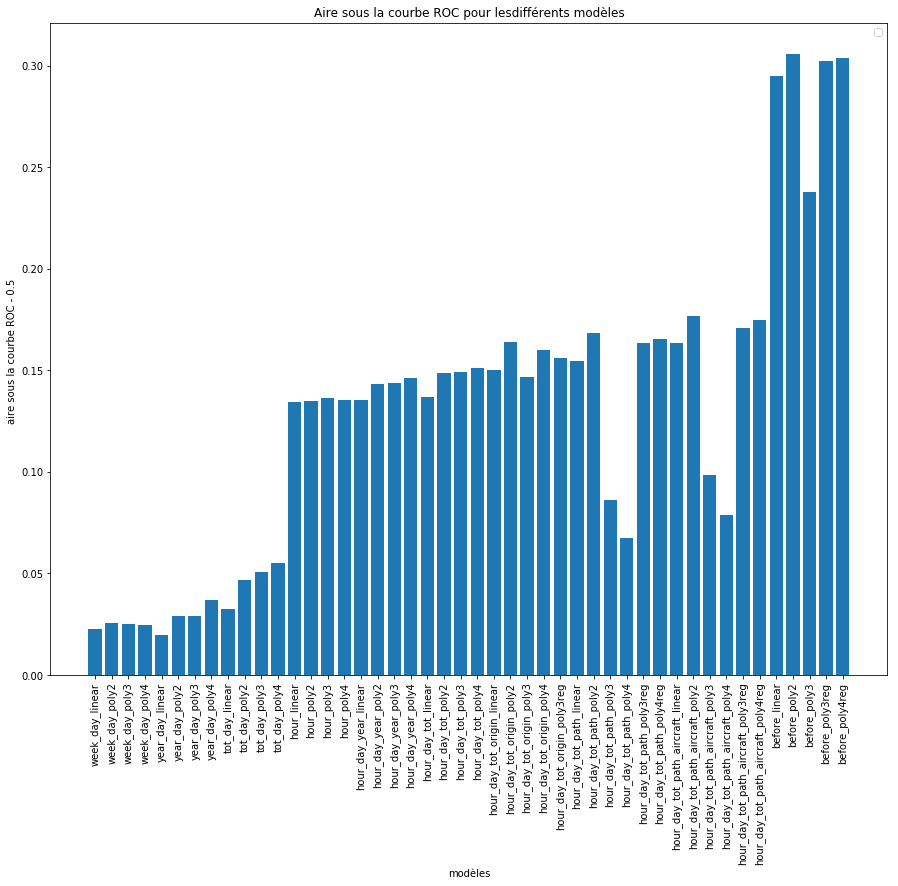

In [180]:
for i in range (len(liste_roc)):
    liste_roc[i] = liste_roc[i] - 0.5
plt.figure(figsize=(15,12))
plt.title('Aire sous la courbe ROC pour lesdifférents modèles')
plt.bar(liste_name[:],liste_roc[:])
plt.legend(loc = 'modele')
        
plt.axis('tight')
plt.ylabel('aire sous la courbe ROC - 0.5 ')
plt.xlabel('modèles')

plt.xticks(rotation=90)
plt.savefig('pict_rocmodels.png', dpi=400)
plt.show()  